In [6]:
import numpy as np
import pandas as pd
from scipy import sparse

from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam

from datetime import datetime
import json
from collections import defaultdict
import itertools

import os

from prod_slda.model import ProdSLDA
from prod_slda.data_utils import *

In [7]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [8]:
# ----- EXPERIMENT HPARAMS -----
META_FEATURES   = ['pos_bigrams','formality','emoji_task', 'casing','punc_tags', 'sentiment_task']
EXPERIMENT_NAME = '_'.join(META_FEATURES)

# ----- DATA HPARAMS -----
OUT_DIR       = '/mnt/swordfish-pool2/ndeas/prob_models/final_results/' #'/burg/nlp/users/zfh2000/style_results'

DATA_SRC      = '/mnt/swordfish-pool2/ndeas/prob_models/data/enron_processed.json' #'/burg/nlp/users/zfh2000/enron_processed.json'
SPLITS_PATH   = '/mnt/swordfish-pool2/ndeas/prob_models/data/authors_splits.json' #'/burg/home/zfh2000/styletopicmodeling/scripts/authors_splits.json'
SYNTHETIC_SRC = '/mnt/swordfish-pool2/ndeas/prob_models/data/gpt_4_enron_processed.json' #'/burg/nlp/users/zfh2000/gpt_4_enron_processed.json'

BATCH_SIZE  = 128
NUM_WORKERS = 4

MAX_DF = 0.7
MIN_DF = 20

NUM_EPOCHS = 30

DEVICE = torch.device('cuda:1')

DATA_DIR_PATH = os.path.join(OUT_DIR,EXPERIMENT_NAME, f'maxdf{MAX_DF}_mindf{MIN_DF}_DATA')

# Data Setup 

## Data Preprocessing/Loading

In [9]:
if not os.path.exists(DATA_DIR_PATH):
    bows, meta_vectorized, vectorizer, raw_text, authors_json, meta_features_to_names = prepare_data(DATA_SRC,
                 SYNTHETIC_SRC,
                 SPLITS_PATH,
                 META_FEATURES,
                 DATA_DIR_PATH,
                 max_df = MAX_DF,
                 min_df = MIN_DF)
else:
    print(f"LOADING FROM {DATA_DIR_PATH}")
    
    bows, meta_vectorized, vectorizer, raw_text, authors_json, meta_features_to_names = load_data(DATA_DIR_PATH)   

LOADING FROM /mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/maxdf0.7_mindf20_DATA


In [10]:
NUM_DOCS   = bows['training'].shape[0]
VOCAB_SIZE = bows['training'].shape[1]
META_SIZE  = {k:v.shape[1] for k,v in meta_vectorized['training'].items()}
IDX_TO_TERM = {v:k for k,v in vectorizer.vocabulary_.items()}

In [11]:
print(f'BOW Dims: {bows["training"].shape}')
print(f'META Dims: {META_SIZE}')

BOW Dims: (66668, 3098)
META Dims: {'casing': 3, 'emoji_task': 20, 'formality': 2, 'pos_bigrams': 324, 'punc_tags': 20, 'sentiment_task': 3}


## Dataset

In [12]:
dataset = DocMetaData(bows['training'], meta_vectorized['training'])
eval_dataset = DocMetaData(bows['holdout'], meta_vectorized['holdout'], split_halves = True)

In [13]:
dl = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)
eval_dl = DataLoader(eval_dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)

In [14]:
train_test_batch = next(iter(dl))
for k, v in train_test_batch.items():
    if isinstance(v, dict):
        print(k)
        for k1, v1 in v.items():
             print(f'\t{k1:15s}: {str(v1.shape)}')
    else:
        print(f'{k:15s}\n\t{"":15s}: {v.shape}')

bow            
	               : torch.Size([128, 3098])
meta
	casing         : torch.Size([128, 3])
	emoji_task     : torch.Size([128, 20])
	formality      : torch.Size([128, 2])
	pos_bigrams    : torch.Size([128, 324])
	punc_tags      : torch.Size([128, 20])
	sentiment_task : torch.Size([128, 3])


In [15]:
eval_test_batch = next(iter(eval_dl))
for k, v in eval_test_batch.items():
    if isinstance(v, dict):
        print(k)
        for k1, v1 in v.items():
             print(f'\t{k1:15s}: {str(v1.shape)}')
    else:
        print(f'{k:15s}\n\t{"":15s}: {v.shape}')

bow            
	               : torch.Size([128, 3098])
meta
	casing         : torch.Size([128, 3])
	emoji_task     : torch.Size([128, 20])
	formality      : torch.Size([128, 2])
	pos_bigrams    : torch.Size([128, 324])
	punc_tags      : torch.Size([128, 20])
	sentiment_task : torch.Size([128, 3])
bow_h1         
	               : torch.Size([128, 3098])
bow_h2         
	               : torch.Size([128, 3098])


# Training

In [30]:
# ----- TRAINING HPARAMS -----

LRS = [1e-3]
BETAS = (0.99, 0.999)
EPS   = 1e-8
CLIP_NORM = 10.
# ADAM_ARGS = {'lr': LR, 'betas': BETAS, 'eps': EPS, 'clip_norm': CLIP_NORM}

# ----- MODEL HPARAMS -----

NUM_TOPICS_BOTHS = [5, 10, 20]
TOPIC_HIDDEN_DIM = 128
STYLE_HIDDEN_DIM = 64
DROPOUT    = 0

THETA_PRIOR_DIST = 'gaussian'
THETA_PRIOR_LOC = 0.
THETA_PRIOR_SCALES = [1., 3., 5.]

KAPPA_PRIOR_DISTS = ['gaussian']
KAPPA_PRIOR_LOC = 0.
KAPPA_PRIOR_SCALES = [1., 3., 5.]

STYLE_TOPIC_LINK = 'kappa_doc'

HPARAM_QUART = 1

In [31]:
hparam_combos = itertools.product(LRS, NUM_TOPICS_BOTHS, THETA_PRIOR_SCALES, KAPPA_PRIOR_DISTS, KAPPA_PRIOR_SCALES)
hparam_combos = [dict(zip(['lr', 'num_topics', 'theta_prior_scale', 'kappa_prior_dist', 'kappa_prior_scale'], list(hparam_combo))) for hparam_combo in hparam_combos]
for i, combo in enumerate(hparam_combos):
    hparam_combos[i]['num_styles'] = combo['num_topics']

In [32]:
hp_start = HPARAM_QUART * (len(hparam_combos)//4 + 1)
hp_end   = (HPARAM_QUART + 1) * (len(hparam_combos)//4 + 1)
hparam_combos = hparam_combos[hp_start:hp_end]

# Tuning 

In [33]:
def train_epochs(prod_slda, svi, train_dl, eval_dl, num_epochs, device, last_elbos = 5):
    total_epochs = 0
    train_elbo = []
    val_elbo = []

    print("---TRAINING---")
    for epoch in range(num_epochs):

        epoch_elbo = 0.
        prod_slda.train()
        for batch in tqdm(train_dl):

            batch = batch_to_device(batch, device)

            bow = batch['bow']
            meta = batch['meta']

            epoch_elbo += svi.step(bow, meta)


        eval_elbo = 0
        prod_slda.eval()
        with torch.no_grad():
            for batch in tqdm(eval_dl):

                batch = batch_to_device(batch, device)

                bow = batch['bow']
                meta = batch['meta']

                eval_elbo += svi.evaluate_loss(bow, meta)           


        print(f'Epoch {epoch}: {epoch_elbo:.3f}')
        print(f'Epoch {epoch}: Eval: {eval_elbo:.3f}')

        train_elbo.append(epoch_elbo)
        val_elbo.append(eval_elbo)
        total_epochs +=1

        if len(val_elbo) > last_elbos:
            val_elbo_changes = [val_elbo[i] - val_elbo[i-1] for i in range(len(val_elbo) - last_elbos, len(val_elbo))]
            if np.mean(val_elbo_changes) > 0:
                print('Val ELBO diverging, stopping fitting')
                break
                
    return train_elbo, val_elbo, total_epochs

In [34]:
def plot_elbos(train_elbo, val_elbo, path):
    plt.plot(range(len(train_elbo)), [e/len(dl.dataset) for e in train_elbo], label = 'In-Sample')
    plt.plot(range(len(val_elbo)), [e/len(eval_dl.dataset) for e in val_elbo], label = 'Out-Sample')

    plt.legend()
    plt.xlabel('# Iterations')
    plt.ylabel('ELBO')

    plt.savefig(os.path.join(path, 'converge_plot.png'), dpi = 500, facecolor = None)

In [35]:
base_info = {
    'experiment_name': EXPERIMENT_NAME,
    'topic_hidden_dim': TOPIC_HIDDEN_DIM,
    'style_hidden_dim': STYLE_HIDDEN_DIM,
    'dropout': DROPOUT,
    'theta_prior_dist': THETA_PRIOR_DIST,
    'theta_prior_loc': THETA_PRIOR_LOC,
    'kappa_prior_loc': KAPPA_PRIOR_LOC,
    'style_topic_link': STYLE_TOPIC_LINK,
    'num_epochs': NUM_EPOCHS,
    'betas': BETAS,
    'eps': EPS,
    'batch_size': BATCH_SIZE,
    'clip_norm': CLIP_NORM,
    'num_workers': NUM_WORKERS,
    'device': DEVICE.type,
    'meta_features': META_FEATURES,
    'DATA_SRC': DATA_SRC,
    'SPLITS_PATH': SPLITS_PATH,
    'SYNTHETIC_SRC': SYNTHETIC_SRC,
    'MAX_DF': MAX_DF,
    'MIN_DF': MIN_DF,
}

LAST_ELBOS = 10

Beginning training for hparams: {'lr': 0.001, 'num_topics': 5, 'theta_prior_scale': 5.0, 'kappa_prior_dist': 'gaussian', 'kappa_prior_scale': 3.0, 'num_styles': 5}
---TRAINING---


100%|██████████| 179/179 [00:08<00:00, 21.23it/s]


Epoch 0: 16936.779
Epoch 0: Eval: 5365.939


100%|██████████| 179/179 [00:08<00:00, 21.17it/s]


Epoch 1: 15606.270
Epoch 1: Eval: 5188.238


100%|██████████| 179/179 [00:08<00:00, 21.05it/s]


Epoch 2: 15296.889
Epoch 2: Eval: 5151.791


100%|██████████| 179/179 [00:08<00:00, 20.56it/s]


Epoch 3: 15155.499
Epoch 3: Eval: 5125.064


100%|██████████| 179/179 [00:08<00:00, 20.83it/s]


Epoch 4: 15104.067
Epoch 4: Eval: 5115.359


100%|██████████| 179/179 [00:08<00:00, 21.71it/s]


Epoch 5: 15051.442
Epoch 5: Eval: 5103.169


100%|██████████| 179/179 [00:08<00:00, 20.96it/s]


Epoch 6: 15021.590
Epoch 6: Eval: 5097.830


100%|██████████| 179/179 [00:08<00:00, 21.84it/s]


Epoch 7: 15005.977
Epoch 7: Eval: 5081.600


100%|██████████| 179/179 [00:08<00:00, 20.40it/s]


Epoch 8: 14991.616
Epoch 8: Eval: 5054.831


100%|██████████| 179/179 [00:08<00:00, 21.48it/s]


Epoch 9: 14988.538
Epoch 9: Eval: 5219.092


100%|██████████| 179/179 [00:08<00:00, 21.48it/s]


Epoch 10: 14976.475
Epoch 10: Eval: 5092.557


100%|██████████| 179/179 [00:08<00:00, 21.24it/s]


Epoch 11: 14969.696
Epoch 11: Eval: 5106.048


100%|██████████| 179/179 [00:08<00:00, 21.76it/s]


Epoch 12: 14964.260
Epoch 12: Eval: 5093.696


100%|██████████| 179/179 [00:08<00:00, 20.87it/s]


Epoch 13: 14960.234
Epoch 13: Eval: 5093.345


100%|██████████| 179/179 [00:08<00:00, 20.93it/s]


Epoch 14: 14957.978
Epoch 14: Eval: 5091.749


100%|██████████| 179/179 [00:08<00:00, 21.07it/s]


Epoch 15: 14958.289
Epoch 15: Eval: 5062.475


100%|██████████| 179/179 [00:08<00:00, 20.01it/s]


Epoch 16: 14951.108
Epoch 16: Eval: 5073.473


100%|██████████| 179/179 [00:08<00:00, 20.68it/s]


Epoch 17: 14942.198
Epoch 17: Eval: 5087.618
Val ELBO diverging, stopping fitting
Model saved to /mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_11_36_36/model_epoch18_5087.617931365967.pt
Beginning training for hparams: {'lr': 0.001, 'num_topics': 5, 'theta_prior_scale': 5.0, 'kappa_prior_dist': 'gaussian', 'kappa_prior_scale': 5.0, 'num_styles': 5}
---TRAINING---


100%|██████████| 179/179 [00:08<00:00, 20.20it/s]


Epoch 0: 17144.718
Epoch 0: Eval: 5495.466


100%|██████████| 179/179 [00:10<00:00, 17.58it/s]


Epoch 1: 15902.361
Epoch 1: Eval: 5337.380


100%|██████████| 179/179 [00:08<00:00, 20.73it/s]


Epoch 2: 15554.168
Epoch 2: Eval: 5264.723


100%|██████████| 179/179 [00:08<00:00, 21.26it/s]


Epoch 3: 15438.989
Epoch 3: Eval: 5265.823


100%|██████████| 179/179 [00:08<00:00, 20.98it/s]


Epoch 4: 15334.567
Epoch 4: Eval: 5231.823


100%|██████████| 179/179 [00:08<00:00, 20.98it/s]


Epoch 5: 15293.985
Epoch 5: Eval: 5130.478


100%|██████████| 179/179 [00:08<00:00, 20.27it/s]


Epoch 6: 15267.709
Epoch 6: Eval: 5226.774


100%|██████████| 179/179 [00:08<00:00, 21.15it/s]


Epoch 7: 15253.725
Epoch 7: Eval: 5199.366


100%|██████████| 179/179 [00:08<00:00, 21.20it/s]


Epoch 8: 15233.951
Epoch 8: Eval: 5192.573


100%|██████████| 179/179 [00:08<00:00, 20.91it/s]


Epoch 9: 15226.160
Epoch 9: Eval: 5191.578


100%|██████████| 179/179 [00:07<00:00, 22.53it/s]


Epoch 10: 15223.517
Epoch 10: Eval: 5182.742


100%|██████████| 179/179 [00:08<00:00, 21.38it/s]


Epoch 11: 15211.992
Epoch 11: Eval: 5180.068


100%|██████████| 179/179 [00:08<00:00, 20.89it/s]


Epoch 12: 15214.588
Epoch 12: Eval: 5218.723


100%|██████████| 179/179 [00:08<00:00, 21.53it/s]


Epoch 13: 15226.989
Epoch 13: Eval: 5201.949


100%|██████████| 179/179 [00:08<00:00, 21.28it/s]


Epoch 14: 15210.699
Epoch 14: Eval: 5194.560


100%|██████████| 179/179 [00:08<00:00, 21.47it/s]


Epoch 15: 15198.794
Epoch 15: Eval: 5340.325
Val ELBO diverging, stopping fitting
Model saved to /mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_11_47_25/model_epoch16_5340.325119018555.pt
Beginning training for hparams: {'lr': 0.001, 'num_topics': 10, 'theta_prior_scale': 1.0, 'kappa_prior_dist': 'gaussian', 'kappa_prior_scale': 1.0, 'num_styles': 10}
---TRAINING---


100%|██████████| 179/179 [00:08<00:00, 21.71it/s]


Epoch 0: 16682.670
Epoch 0: Eval: 10578.374


100%|██████████| 179/179 [00:08<00:00, 20.99it/s]


Epoch 1: 15036.515
Epoch 1: Eval: 5011.321


100%|██████████| 179/179 [00:08<00:00, 21.98it/s]


Epoch 2: 14599.288
Epoch 2: Eval: 4991.579


100%|██████████| 179/179 [00:08<00:00, 22.26it/s]


Epoch 3: 14447.498
Epoch 3: Eval: 4955.220


100%|██████████| 179/179 [00:08<00:00, 21.53it/s]


Epoch 4: 14344.878
Epoch 4: Eval: 4871.601


100%|██████████| 179/179 [00:08<00:00, 21.63it/s]


Epoch 5: 14294.246
Epoch 5: Eval: 4917.300


100%|██████████| 179/179 [00:08<00:00, 20.84it/s]


Epoch 6: 14250.806
Epoch 6: Eval: 4856.614


100%|██████████| 179/179 [00:08<00:00, 21.33it/s]


Epoch 7: 14211.582
Epoch 7: Eval: 4813.382


100%|██████████| 179/179 [00:08<00:00, 21.97it/s]


Epoch 8: 14194.500
Epoch 8: Eval: 4802.169


100%|██████████| 179/179 [00:08<00:00, 21.82it/s]


Epoch 9: 14164.900
Epoch 9: Eval: 4808.505


100%|██████████| 179/179 [00:08<00:00, 21.85it/s]


Epoch 10: 14151.874
Epoch 10: Eval: 4790.515


100%|██████████| 179/179 [00:08<00:00, 21.37it/s]


Epoch 11: 14141.097
Epoch 11: Eval: 4791.468


100%|██████████| 179/179 [00:08<00:00, 21.02it/s]


Epoch 12: 14128.643
Epoch 12: Eval: 4831.196


100%|██████████| 179/179 [00:08<00:00, 20.91it/s]


Epoch 13: 14119.279
Epoch 13: Eval: 4798.300


100%|██████████| 179/179 [00:08<00:00, 21.83it/s]


Epoch 14: 14120.280
Epoch 14: Eval: 4855.536


100%|██████████| 179/179 [00:08<00:00, 21.55it/s]


Epoch 15: 14112.734
Epoch 15: Eval: 4788.219


100%|██████████| 179/179 [00:08<00:00, 21.99it/s]


Epoch 16: 14097.675
Epoch 16: Eval: 4802.791


100%|██████████| 179/179 [00:08<00:00, 21.11it/s]


Epoch 17: 14097.706
Epoch 17: Eval: 4784.723


100%|██████████| 179/179 [00:07<00:00, 23.04it/s]


Epoch 18: 14088.965
Epoch 18: Eval: 4806.112
Val ELBO diverging, stopping fitting
Model saved to /mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_11_57_05/model_epoch19_4806.112176895142.pt
Beginning training for hparams: {'lr': 0.001, 'num_topics': 10, 'theta_prior_scale': 1.0, 'kappa_prior_dist': 'gaussian', 'kappa_prior_scale': 3.0, 'num_styles': 10}
---TRAINING---


100%|██████████| 179/179 [00:08<00:00, 21.63it/s]


Epoch 0: 16277.920
Epoch 0: Eval: 5816.880


100%|██████████| 179/179 [00:08<00:00, 22.14it/s]


Epoch 1: 14921.035
Epoch 1: Eval: 5188.314


100%|██████████| 179/179 [00:08<00:00, 21.92it/s]


Epoch 2: 15123.350
Epoch 2: Eval: 5909.839


100%|██████████| 179/179 [00:08<00:00, 22.26it/s]


Epoch 3: 14840.747
Epoch 3: Eval: 5169.832


100%|██████████| 179/179 [00:07<00:00, 22.59it/s]


Epoch 4: 14607.013
Epoch 4: Eval: 5067.770


100%|██████████| 179/179 [00:08<00:00, 21.61it/s]


Epoch 5: 14551.644
Epoch 5: Eval: 5552.666


100%|██████████| 179/179 [00:08<00:00, 21.36it/s]


Epoch 6: 14686.508
Epoch 6: Eval: 5076.509


100%|██████████| 179/179 [00:08<00:00, 20.96it/s]


Epoch 7: 14559.046
Epoch 7: Eval: 5190.036


100%|██████████| 179/179 [00:08<00:00, 22.19it/s]


Epoch 8: 14503.362
Epoch 8: Eval: 5071.442


100%|██████████| 179/179 [00:08<00:00, 21.82it/s]


Epoch 9: 14445.377
Epoch 9: Eval: 5051.274


100%|██████████| 179/179 [00:08<00:00, 21.81it/s]


Epoch 10: 14443.323
Epoch 10: Eval: 4971.190


100%|██████████| 179/179 [00:07<00:00, 22.84it/s]


Epoch 11: 14320.462
Epoch 11: Eval: 4997.624


100%|██████████| 179/179 [00:08<00:00, 22.33it/s]


Epoch 12: 14367.070
Epoch 12: Eval: 4965.644


100%|██████████| 179/179 [00:08<00:00, 21.98it/s]


Epoch 13: 14360.314
Epoch 13: Eval: 5027.117


100%|██████████| 179/179 [00:08<00:00, 20.95it/s]


Epoch 14: 14339.512
Epoch 14: Eval: 4990.191


100%|██████████| 179/179 [00:08<00:00, 21.74it/s]


Epoch 15: 14416.249
Epoch 15: Eval: 5114.122


100%|██████████| 179/179 [00:08<00:00, 21.43it/s]


Epoch 16: 14382.960
Epoch 16: Eval: 5477.437
Val ELBO diverging, stopping fitting
Model saved to /mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_12_08_18/model_epoch17_5477.437126159668.pt
Beginning training for hparams: {'lr': 0.001, 'num_topics': 10, 'theta_prior_scale': 1.0, 'kappa_prior_dist': 'gaussian', 'kappa_prior_scale': 5.0, 'num_styles': 10}
---TRAINING---


100%|██████████| 179/179 [00:08<00:00, 20.82it/s]


Epoch 0: 16758.976
Epoch 0: Eval: 10508.478


100%|██████████| 179/179 [00:08<00:00, 22.27it/s]


Epoch 1: 15727.227
Epoch 1: Eval: 5374.673


100%|██████████| 179/179 [00:08<00:00, 21.38it/s]


Epoch 2: 15411.591
Epoch 2: Eval: 7148.943


100%|██████████| 179/179 [00:08<00:00, 21.71it/s]


Epoch 3: 15283.262
Epoch 3: Eval: 13621.548


100%|██████████| 179/179 [00:08<00:00, 21.09it/s]


Epoch 4: 15021.408
Epoch 4: Eval: 5982.460


100%|██████████| 179/179 [00:08<00:00, 22.26it/s]


Epoch 5: 15036.987
Epoch 5: Eval: 7372.463


100%|██████████| 179/179 [00:08<00:00, 22.15it/s]


Epoch 6: 14919.534
Epoch 6: Eval: 5441.716


100%|██████████| 179/179 [00:07<00:00, 23.24it/s]


Epoch 7: 14963.947
Epoch 7: Eval: 5463.658


100%|██████████| 179/179 [00:08<00:00, 22.25it/s]


Epoch 8: 14950.032
Epoch 8: Eval: 5820.282


100%|██████████| 179/179 [00:07<00:00, 22.64it/s]


Epoch 9: 14938.401
Epoch 9: Eval: 6332.883


100%|██████████| 179/179 [00:08<00:00, 21.09it/s]


Epoch 10: 15062.969
Epoch 10: Eval: 5216.823


100%|██████████| 179/179 [00:08<00:00, 22.35it/s]


Epoch 11: 15046.674
Epoch 11: Eval: 5554.299
Val ELBO diverging, stopping fitting
Model saved to /mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_12_18_10/model_epoch12_5554.298946380615.pt
Beginning training for hparams: {'lr': 0.001, 'num_topics': 10, 'theta_prior_scale': 3.0, 'kappa_prior_dist': 'gaussian', 'kappa_prior_scale': 1.0, 'num_styles': 10}
---TRAINING---


100%|██████████| 179/179 [00:08<00:00, 21.82it/s]


Epoch 0: 17018.851
Epoch 0: Eval: 5378.475


100%|██████████| 179/179 [00:07<00:00, 22.68it/s]


Epoch 1: 15513.615
Epoch 1: Eval: 5433.417


100%|██████████| 179/179 [00:08<00:00, 21.35it/s]


Epoch 2: 15184.689
Epoch 2: Eval: 5222.128


100%|██████████| 179/179 [00:08<00:00, 21.86it/s]


Epoch 3: 15028.867
Epoch 3: Eval: 5165.298


100%|██████████| 179/179 [00:08<00:00, 21.28it/s]


Epoch 4: 14984.428
Epoch 4: Eval: 5156.975


100%|██████████| 179/179 [00:08<00:00, 21.93it/s]


Epoch 5: 14873.843
Epoch 5: Eval: 5121.560


100%|██████████| 179/179 [00:08<00:00, 21.54it/s]


Epoch 6: 14840.162
Epoch 6: Eval: 5062.810


100%|██████████| 179/179 [00:08<00:00, 20.66it/s]


Epoch 7: 14815.259
Epoch 7: Eval: 5017.323


100%|██████████| 179/179 [00:08<00:00, 22.06it/s]


Epoch 8: 14790.445
Epoch 8: Eval: 5091.628


100%|██████████| 179/179 [00:08<00:00, 22.12it/s]


Epoch 9: 14768.526
Epoch 9: Eval: 5039.361


100%|██████████| 179/179 [00:08<00:00, 21.88it/s]


Epoch 10: 14751.274
Epoch 10: Eval: 5042.410


100%|██████████| 179/179 [00:08<00:00, 22.35it/s]


Epoch 11: 14729.427
Epoch 11: Eval: 5048.298


100%|██████████| 179/179 [00:07<00:00, 22.85it/s]


Epoch 12: 14730.829
Epoch 12: Eval: 5000.923


100%|██████████| 179/179 [00:08<00:00, 21.39it/s]


Epoch 13: 14702.246
Epoch 13: Eval: 4988.171


100%|██████████| 179/179 [00:07<00:00, 22.47it/s]


Epoch 14: 14705.374
Epoch 14: Eval: 5050.884


100%|██████████| 179/179 [00:08<00:00, 21.69it/s]


Epoch 15: 14700.233
Epoch 15: Eval: 4998.576


100%|██████████| 179/179 [00:07<00:00, 22.58it/s]


Epoch 16: 14689.181
Epoch 16: Eval: 5016.757


100%|██████████| 179/179 [00:08<00:00, 21.63it/s]


Epoch 17: 14689.462
Epoch 17: Eval: 5009.357


100%|██████████| 179/179 [00:08<00:00, 21.32it/s]


Epoch 18: 14678.670
Epoch 18: Eval: 4994.440


100%|██████████| 179/179 [00:08<00:00, 21.22it/s]


Epoch 19: 14672.154
Epoch 19: Eval: 4995.404


100%|██████████| 179/179 [00:08<00:00, 21.76it/s]


Epoch 20: 14667.773
Epoch 20: Eval: 5030.082


100%|██████████| 179/179 [00:08<00:00, 21.26it/s]


Epoch 21: 14666.913
Epoch 21: Eval: 5029.115


100%|██████████| 179/179 [00:08<00:00, 21.91it/s]


Epoch 22: 14663.341
Epoch 22: Eval: 4980.430


100%|██████████| 179/179 [00:08<00:00, 21.48it/s]


Epoch 23: 14662.326
Epoch 23: Eval: 4990.018
Val ELBO diverging, stopping fitting
Model saved to /mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_12_25_09/model_epoch24_4990.017833709717.pt
Beginning training for hparams: {'lr': 0.001, 'num_topics': 10, 'theta_prior_scale': 3.0, 'kappa_prior_dist': 'gaussian', 'kappa_prior_scale': 3.0, 'num_styles': 10}
---TRAINING---


100%|██████████| 179/179 [00:08<00:00, 21.48it/s]


Epoch 0: 17215.714
Epoch 0: Eval: 5537.723


100%|██████████| 179/179 [00:08<00:00, 21.85it/s]


Epoch 1: 15752.500
Epoch 1: Eval: 5369.373


100%|██████████| 179/179 [00:08<00:00, 21.76it/s]


Epoch 2: 15391.108
Epoch 2: Eval: 5559.333


100%|██████████| 179/179 [00:08<00:00, 22.11it/s]


Epoch 3: 15198.262
Epoch 3: Eval: 5232.604


100%|██████████| 179/179 [00:08<00:00, 21.59it/s]


Epoch 4: 15128.754
Epoch 4: Eval: 5282.144


100%|██████████| 179/179 [00:07<00:00, 22.44it/s]


Epoch 5: 15048.648
Epoch 5: Eval: 5125.846


100%|██████████| 179/179 [00:08<00:00, 21.76it/s]


Epoch 6: 14988.441
Epoch 6: Eval: 5163.368


100%|██████████| 179/179 [00:08<00:00, 22.06it/s]


Epoch 7: 14954.866
Epoch 7: Eval: 5226.313


100%|██████████| 179/179 [00:08<00:00, 22.11it/s]


Epoch 8: 14936.117
Epoch 8: Eval: 5098.789


100%|██████████| 179/179 [00:08<00:00, 21.77it/s]


Epoch 9: 14905.009
Epoch 9: Eval: 5124.923


100%|██████████| 179/179 [00:07<00:00, 23.09it/s]


Epoch 10: 14902.719
Epoch 10: Eval: 5147.979


100%|██████████| 179/179 [00:08<00:00, 20.76it/s]


Epoch 11: 14875.339
Epoch 11: Eval: 5099.276


100%|██████████| 179/179 [00:08<00:00, 20.93it/s]


Epoch 12: 14888.967
Epoch 12: Eval: 5079.499


100%|██████████| 179/179 [00:07<00:00, 23.16it/s]


Epoch 13: 14902.962
Epoch 13: Eval: 5112.540


100%|██████████| 179/179 [00:08<00:00, 22.23it/s]


Epoch 14: 14849.772
Epoch 14: Eval: 5087.562


100%|██████████| 179/179 [00:08<00:00, 21.78it/s]


Epoch 15: 14851.935
Epoch 15: Eval: 5076.628


100%|██████████| 179/179 [00:08<00:00, 21.83it/s]


Epoch 16: 14825.956
Epoch 16: Eval: 5082.145


100%|██████████| 179/179 [00:08<00:00, 21.62it/s]


Epoch 17: 14853.819
Epoch 17: Eval: 5107.314


100%|██████████| 179/179 [00:07<00:00, 22.39it/s]


Epoch 18: 14811.929
Epoch 18: Eval: 5070.688


100%|██████████| 179/179 [00:08<00:00, 21.41it/s]


Epoch 19: 14805.476
Epoch 19: Eval: 5084.240


100%|██████████| 179/179 [00:07<00:00, 22.42it/s]


Epoch 20: 14798.654
Epoch 20: Eval: 5061.395


100%|██████████| 179/179 [00:08<00:00, 22.11it/s]


Epoch 21: 14793.679
Epoch 21: Eval: 5075.897


100%|██████████| 179/179 [00:08<00:00, 21.87it/s]


Epoch 22: 14791.863
Epoch 22: Eval: 5057.232


100%|██████████| 179/179 [00:07<00:00, 23.22it/s]


Epoch 23: 14781.599
Epoch 23: Eval: 5136.832
Val ELBO diverging, stopping fitting
Model saved to /mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_12_39_04/model_epoch24_5136.832389831543.pt


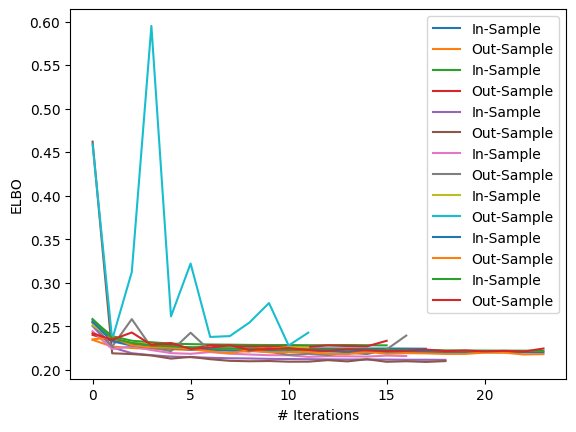

In [36]:
for hparam in hparam_combos:
    
    print(f'Beginning training for hparams: {str(hparam)}')
    
    # Create and save configuration info
    date = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")

    info = dict(hparam, **base_info)
    info['date'] = date
    
    PATH = os.path.join(OUT_DIR, EXPERIMENT_NAME, date)
    os.makedirs(PATH, exist_ok=True)
    with open(os.path.join(PATH, 'info.json'), 'w') as f:
        json.dump(info, f, indent=4)
        
    # Create Model
    prod_slda = ProdSLDA(
        vocab_size = VOCAB_SIZE,
        meta_sizes  = META_SIZE,
        num_topics = info['num_topics'], num_styles = info['num_styles'], 
        topic_hidden = TOPIC_HIDDEN_DIM, style_hidden = STYLE_HIDDEN_DIM, dropout = DROPOUT, 
        theta_prior_dist = THETA_PRIOR_DIST, 
        theta_prior_loc = THETA_PRIOR_LOC, theta_prior_scale = info['theta_prior_scale'],
        kappa_prior_dist = info['kappa_prior_dist'], 
        kappa_prior_loc = KAPPA_PRIOR_LOC, kappa_prior_scale = info['kappa_prior_scale'],
        style_topic_link = STYLE_TOPIC_LINK,
    ).to(DEVICE)
    
    # Setup Fitting
    pyro.clear_param_store()
    prod_slda.train()
    
    adam_args = {'lr': info['lr'], 'betas': BETAS, 'eps': EPS, 'clip_norm': CLIP_NORM}
    
    optim = pyro.optim.ClippedAdam(adam_args)

    svi = SVI(
        pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
        pyro.poutine.scale(prod_slda.guide, BATCH_SIZE/len(dl.dataset)),
        optim,
        loss = TraceMeanField_ELBO()
    )
    
    train_elbo, val_elbo, total_epochs = train_epochs(prod_slda, svi, 
                                        dl, eval_dl, 
                                        NUM_EPOCHS, DEVICE,
                                        last_elbos = LAST_ELBOS)
    
    # Save recorded elbos
    elbos = pd.DataFrame({'train_elbo': train_elbo, 'val_elbo': val_elbo})
    elbos.to_csv(os.path.join(PATH, 'elbos.json'), index = False)
    
    # Save convergence plot
    plot_elbos(train_elbo, val_elbo, PATH)
    
    # Save final model
    path = os.path.join(PATH, f'model_epoch{total_epochs}_{val_elbo[-1]}.pt')
    prod_slda.eval()
    torch.save(prod_slda, path)
    print(f'Model saved to {path}')
    
    

## Setup

In [ ]:
prod_slda = ProdSLDA(
    vocab_size = VOCAB_SIZE,
    meta_sizes  = META_SIZE,
    num_topics = NUM_TOPICS, num_styles = NUM_STYLES, 
    hidden = HIDDEN_DIM, dropout = DROPOUT, 
    theta_prior_dist = THETA_PRIOR_DIST, 
    theta_prior_loc = THETA_PRIOR_LOC, theta_prior_scale = THETA_PRIOR_SCALE,
    kappa_prior_dist = KAPPA_PRIOR_DIST, 
    kappa_prior_loc = KAPPA_PRIOR_LOC, kappa_prior_scale = KAPPA_PRIOR_SCALE,
    style_topic_link = STYLE_TOPIC_LINK,
).to(DEVICE)

print(prod_slda.beta_document())
print(prod_slda.beta_meta())


## Training 

In [ ]:
%%capture cap --no-stderr
pyro.clear_param_store()
prod_slda.train()

In [ ]:
optim = pyro.optim.ClippedAdam(ADAM_ARGS)

svi = SVI(
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    pyro.poutine.scale(prod_slda.guide, BATCH_SIZE/len(dl.dataset)),
    optim,
    loss = TraceMeanField_ELBO()
)

In [ ]:
total_epochs = 0

In [ ]:
train_elbo = []
val_elbo = []

print("---TRAINING---")
for epoch in range(NUM_EPOCHS):
    
    epoch_elbo = 0.
    prod_slda.train()
    for batch in tqdm(dl):
        
        batch = batch_to_device(batch, DEVICE)
        
        bow = batch['bow']
        meta = batch['meta']
        
        epoch_elbo += svi.step(bow, meta)

    eval_elbo = 0
    prod_slda.eval()
    with torch.no_grad():
        for batch in tqdm(eval_dl):
            
            batch = batch_to_device(batch, DEVICE)
            
            bow = batch['bow']
            meta = batch['meta']
    
            eval_elbo += svi.evaluate_loss(bow, meta)
    
        
    print(f'Epoch {epoch}: {epoch_elbo:.3f}')
    print(f'Epoch {epoch}: Eval: {eval_elbo:.3f}')
    
    train_elbo.append(epoch_elbo)
    val_elbo.append(eval_elbo)
    total_epochs +=1

In [ ]:
path = os.path.join(PATH, f'model_epoch{total_epochs}_{val_elbo[-1]}.pt')
prod_slda.eval()
torch.save(prod_slda, path)
print(f'Saved to {path}')

In [ ]:
plt.plot(range(len(train_elbo)), [e/len(dl.dataset) for e in train_elbo], label = 'In-Sample')
plt.plot(range(len(val_elbo)), [e/len(eval_dl.dataset) for e in val_elbo], label = 'Out-Sample')

plt.legend()
plt.xlabel('# Iterations')
plt.ylabel('ELBO')

plt.savefig(os.path.join(PATH, 'loss_plot_indep.png'), dpi = 600, facecolor = None)


In [ ]:
path = os.path.join(PATH, f'model_epoch{total_epochs}_{val_elbo[-1]}.pt')
prod_slda.eval()
torch.save(prod_slda, path)
print(f'Saved to {path}')

# Eval 

## Reconstruct Perplexity 

In [39]:
def calc_doc_perp(prod_slda, eval_dl, device, use_style = True):
    total_ce, total_count = 0., 0.
    for batch in tqdm(eval_dl):
        for key in batch.keys():
            if isinstance(batch[key], dict):
                for key2 in batch[key].keys():
                    batch[key][key2] = batch[key][key2].to(device)
            else:
                batch[key] = batch[key].to(device)

        ce, count = prod_slda.doc_reconstruct_ce(batch, use_style = use_style)
        total_ce += ce
        total_count += count
    return torch.exp(total_ce/total_count).item()

def calc_style_perp(prod_slda, eval_dl, device):
    total_ce, total_count = 0., 0.
    for batch in tqdm(eval_dl):
        for key in batch.keys():
            if isinstance(batch[key], dict):
                for key2 in batch[key].keys():
                    batch[key][key2] = batch[key][key2].to(device)
            else:
                batch[key] = batch[key].to(device)

        ce, count = prod_slda.style_reconstruct_ce(batch)
        total_ce += ce
        total_count += count
    return torch.exp(total_ce/total_count).item()

In [36]:
prod_slda = torch.load(path).to(DEVICE)

In [40]:
doc_perp      = calc_doc_perp(prod_slda, eval_dl)
doc_only_perp = calc_doc_perp(prod_slda, eval_dl, use_style = False)
style_perp    = calc_style_perp(prod_slda, eval_dl)

100%|██████████| 179/179 [00:12<00:00, 14.10it/s]


In [41]:
print(f'Perp           : {doc_perp:.4f}')
print(f'Perp (No Style): {doc_only_perp:.4f}')
print(f'Style Perp     : {style_perp:.4f}')

Perp           : 3199.2117
Perp (No Style): 3485.7412
Style Perp     : 56.1780


# Examine Topics 

In [52]:
def top_beta_document(model, vectorizer, top_k=20):
    betas_document = model.beta_document()
    features_to_betas = {}
    idx_to_name = {v:k for k,v in vectorizer.vocabulary_.items()}
    for feature, logits in betas_document.items():
        features_to_betas[feature] = []
        num_features = logits.shape[0]
        top_results = torch.topk(logits, top_k, dim=-1)
        
        ids = top_results.indices.cpu().numpy()
        values = top_results.values.cpu().numpy()
        
        for i in tqdm(range(num_features)):
            features_to_betas[feature].append({'values':values[i], 'top':[idx_to_name[idx] for idx in ids[i]]})
                
    return features_to_betas

def top_beta_meta(model, meta_feature_to_names, top_k=20):
    betas_metas = model.beta_meta()
    features_to_betas = {}
    for feature, logits in betas_metas.items():
        idx_to_name = {i:k for i,k in enumerate(meta_feature_to_names[feature])}
        features_to_betas[feature] = []
        num_features = logits.shape[0]
        top_results = torch.topk(logits, min(top_k, logits.shape[1]), dim=-1)
        ids = top_results.indices.cpu().numpy()
        values = top_results.values.cpu().numpy()
        for i in tqdm(range(num_features)):
            features_to_betas[feature].append({'values':values[i], 'top':[idx_to_name[idx] for idx in ids[i]]})
        
    return features_to_betas 

In [53]:
top_words_per_latent = top_beta_document(prod_slda, vectorizer,  top_k=10)
top_meta_per_latent = top_beta_meta(prod_slda, meta_features_to_names, top_k=10)

print('Document Term Info')
for latent, top in top_words_per_latent.items():
    print(f'\t{latent} ({len(top)}):')
    for i, results in enumerate(top):
        print(f'\t\t {latent} ({i}):\n{results["top"]}')
        print()

print('Meta Var Info')
for latent, top in top_meta_per_latent.items():

    print(f'\t{latent} ({len(top)}):')
    for i, results in enumerate(top):
        print(f'\t\t {latent} ({i}):\n{results["top"]}')
        print()

100%|██████████| 10/10 [00:00<00:00, 118483.16it/s]

Document Term Info
	beta_topic (10):
		 beta_topic (0):
['wants', 'termination', 'general', 'caiso', 'q2', 'dial', 'ees', 'process', 'paso', 'results']

		 beta_topic (1):
['supervisor', 'contribute', 'thanx', 'addition', 'pulling', 'documents', 'years', 'brief', 'imbalance', 'gh']

		 beta_topic (2):
['mr', 'effective', 'yahoo', 'agreements', 'team', 'larry', '08', 'set', '20', 'pm']

		 beta_topic (3):
['mike', 'added', 'weekly', 'security', 'll', 'elizabeth', 'business', 'lets', 'kay', 'positions']

		 beta_topic (4):
['713', 'msn', 'delainey', 'look', 'fyi', 'robert', 'number', 'sure', 'think', 'letter']

		 beta_topic (5):
['reminder', 'jackie', 'soon', 'peak', 'theresa', 'cc', 'vacation', 'believe', 'est', 'language']

		 beta_topic (6):
['getting', 'christie', 'official', 'reports', 'pm', 'litigation', 'horton', 'unit', 'outlook', '646']

		 beta_topic (7):
['msn', '853', 'sara', 'analysis', 'fuel', 'car', 'assistance', 'latest', 'explorer', 'monday']

		 beta_topic (8):
['free'